# Phylogenetic analysis of protein and nucleotide sequences for Escherichia coli

In [ ]:
import os
import subprocess

from shutil import which

# Check if the required programs are installed
def environment_setup(name, channel=None):
    channel_option = f"-c {channel}" if channel is not None else ""
    if which(name) is None:
        print(f'{name} is not installed')
        try:
            try:
                print(f"Try installing {name} using mamba")
                %mamba install {channel_option} {name} -y
            except:
                print(f"Try installing {name} using conda")
                %conda install {channel_option} {name} -y
        except:
            print(f"Try installing {name} using pip")
            %pip install {name}
    else:
        print(f'{name} is installed')

environment_setup('matplotlib')

In [46]:
# Importing necessary libraries from BioPython
from Bio import Phylo, AlignIO, SeqIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

file_path = '/Users/dominiquefastus/Downloads/no_dupl_new_ddla_mafft_01.fasta'
alignment = AlignIO.read(file_path, "fasta")
calculator = DistanceCalculator('identity')
contructor = DistanceTreeConstructor(calculator, 'nj')
dist_matrix = calculator.get_distance(alignment)

# tree = contructor.build_tree(alignment)
# print(tree)

nj_tree = contructor.nj(dist_matrix)
upgma_tree = contructor.upgma(dist_matrix)


In [12]:
from ete3 import PhyloTree, TreeStyle, TextFace, add_face_to_node
# t = PhyloTree('/Users/dominiquefastus/Downloads/_nj.240307084710573.o.nh')#, alignment='/Users/dominiquefastus/Downloads/no_dupl_new_ddla_mafft_01.fasta', alg_format='fasta')
t = PhyloTree('/Users/dominiquefastus/master_project/NuStru/nustruEVOL/nustruTREE/TREE/cluster_seq.tre')

In [ ]:
ecoli_ddla_leaf = t.get_leaves_by_name("P0A6J8")[0]
ecoli_subtree = ecoli_ddla_leaf.up.up.up.up
print(ecoli_subtree)

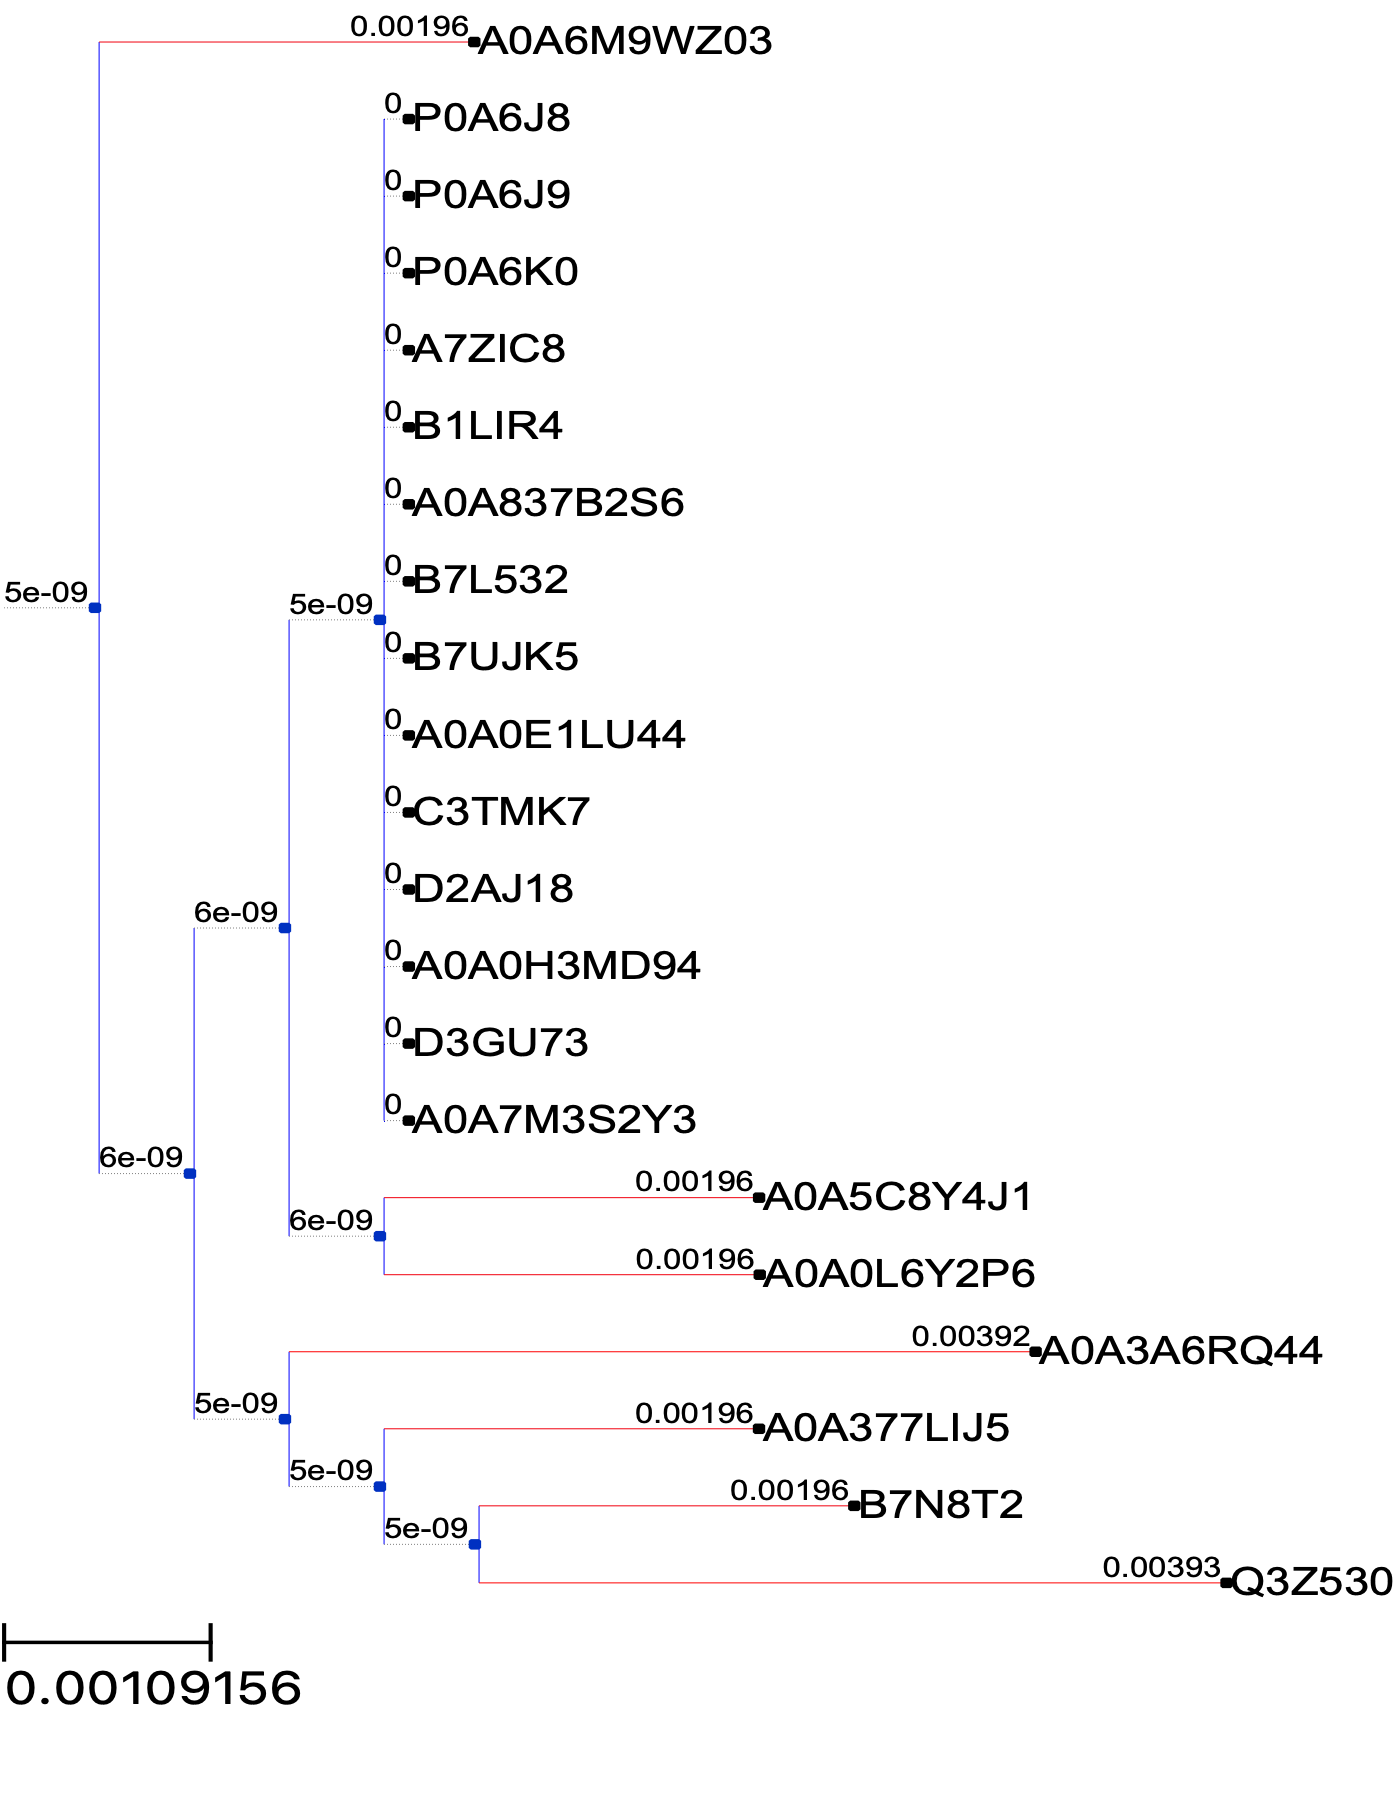

: 

In [21]:
from ete3 import Tree, TreeStyle, NodeStyle
import math

# tree = Tree('/Users/dominiquefastus/master_project/NuStru/nustruEVOL/nustruTREE/TREE/test.tree')
tree = ecoli_subtree

# Function to convert branch length to color
def length_to_color(length, min_length, max_length):
    if length == 0:
        length = min_length  # Avoid math domain error on log(0)
    # Apply a logarithmic transformation
    log_min = math.log(min_length)
    log_max = math.log(max_length)
    log_length = math.log(length)
    normalized_length = (log_length - log_min) / (log_max - log_min)
    # Generate color
    r = int(normalized_length * 255)
    g = 0
    b = 255 - r
    return f'#{r:02x}{g:02x}{b:02x}'

# Calculate the non-zero minimum length to avoid log(0)
non_zero_min_length = min(node.dist for node in tree.traverse() if node.dist > 0)
max_length = max(node.dist for node in tree.traverse())

# Apply styles
for node in tree.traverse():
    nstyle = NodeStyle()
    nstyle["vt_line_color"] = length_to_color(node.dist, non_zero_min_length, max_length)
    nstyle["hz_line_color"] = length_to_color(node.dist, non_zero_min_length, max_length)
    node.set_style(nstyle)

ts1 = TreeStyle()
ts1.show_branch_length = True
ts1.show_leaf_name = False

# Render and display the tree
# tree.show(tree_style=ts)  # Use this if you are running locally and want to display the tree interactively
tree.render('%%inline', w=1400, h=1800, tree_style=ts1)  # Use this if you want to save the tree to a file

In [ ]:
from ete3 import PhyloTree, TreeStyle, SeqMotifFace, faces

# Load the tree
newick_file_path = '/Users/dominiquefastus/Downloads/_nj.240307084710573.o.nh'
t = PhyloTree(newick_file_path)

# Read the alignment from the FASTA file
alignment_file_path = '/Users/dominiquefastus/Downloads/no_dupl_new_ddla_mafft_01.fasta'
alignment = {}
with open(alignment_file_path) as f:
    seq_name = ''
    for line in f:
        if line.startswith('>'):
            seq_name = line.strip().lstrip('>')
            alignment[seq_name] = ''
        else:
            alignment[seq_name] += line.strip()

# Get the sequences from the alignment
alignment_seqs = list(alignment.values())

# Provide secondary structure information in dot-bracket notation
secondary_structure = {
    "seq1": "(((....)))",
    "seq2": "((((....))))",
    # Add secondary structure information for other sequences here
}

# Define tree style
ts = TreeStyle()
ts.show_leaf_name = True

# Add alignment to the tree nodes
for node in t.traverse():
    if not node.is_leaf():
        continue
    seq_name = node.name
    seq_index = list(alignment.keys()).index(seq_name)
    node_seq = alignment_seqs[seq_index]
    seq_face = SeqMotifFace(node_seq, seq_format='seq', seqtype='nt')
    
    # Add secondary structure information
    if seq_name in secondary_structure:
        sec_struct = secondary_structure[seq_name]
        motif_face = faces.MotifFace(sec_struct, seq_type='fold')
        seq_face.add_face(motif_face, column=1, position="aligned")

    node.add_face(seq_face, column=0, position="aligned")

# Render the tree
t.render("aligned_tree_with_sec_structure.png", tree_style=ts)
